# XGBoost model

In this notebook I will build an XGBoost model for our task of classifying stroke status. I used a lot of resources from the website https://xgboosting.com/, as per the bibliography at the end.

First I import all the packages I need to build the model and visualise the data/ output.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

Next I pre-process the training data so that the XGBoost classifier works effectively with it.

In [7]:
df_train = pd.read_csv("stroke_training_dataset.csv")

# Separate features (X) and target (y)
X_train = df_train.drop(columns=['stroke'])
y_train = df_train['stroke']

Next I will separate the features into 2 groups (numeric and categorical) in order to apply the appropriate transformations to each type. This is because the categorical features need to be one-hot encoded in order to convert their text values into a numeric format. Note that I also choose to treat 'hypertension' and 'heart_disease' features as categorical despite them already taking values 0 or 1, this is because the one-hot encoder will be able to handle them well and makes the data more consistent. After this I am then able to build and fit my preprocesser using scikit-learn's 'Pipeline' function.

In [8]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']

categorical_features = [
    'gender', 
    'hypertension', 
    'heart_disease', 
    'ever_married', 
    'work_type', 
    'Residence_type', 
    'smoking_status'
]

# Pipeline for NUMERIC data:
# Step 1: Impute missing values (e.g., in 'bmi') with the median
# Step 2: Scale the data to have a standard mean and variance
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for CATEGORICAL data:
# Step 1: Impute missing values (if any) with the most frequent value
# Step 2: One-hot encode the text labels into binary columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # drop any other columns not specified in the lists i.e. 'id' which isn't a feature
)

# Apply the preprocessor to training data
X_train_processed = preprocessor.fit_transform(X_train)

print("Preprocessing complete!")
print(f"Original X_train shape: {X_train.shape}")
print(f"Processed X_train shape: {X_train_processed.shape}")

Preprocessing complete!
Original X_train shape: (4088, 11)
Processed X_train shape: (4088, 23)


The output from the cell above is now an appropriate input for the XGBoost classifier. It is a NumPy array, with all data numeric.

## Handling class imbalance

The dataset we are working with is highly imbalanced - in the training set, we have 3889 cases of "No stroke" (class 0) and just 199 cases of "Stroke" (class 1). Hence I must carefully approach this in order for the model to not always predict "No stroke" as it will quickly learn that this approach will naively make it highly "accurate". This would result in a model with a very low value of recall i.e. it would miss almost all of the positive ("Stroke") cases, rendering it useless.

In order to address this in the XGBoost model I first decide to tune the 'scale_pos_weight' parameter in the model. This parameter increases the penalty every time the model misclassifies a "Stroke" patient. From my research, the most appropriate starting point is to set it to the ratio of negative cases to positive cases[1], which I calculate below:

$$\text{scale\_pos\_weight} = \frac{\text{Count of `No Stroke' (0)}}{\text{Count of `Stroke' (1)}} = \frac{3889}{199} \approx 19.54. $$

Hence I will now add this parameter when I create my XGBoost model object below. By doing this, I am forcing the model to treat a single "Stroke" case with the same importance as $\approx 19.5$ "No Stroke" cases, effectively balancing the dataset from the model's perspective.

## Building the model 

In [9]:
# Calculate the ratio from y_train as above
scale_pos_weight = 19.54 

# Create the model with this parameter
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42  # Add a random_state for reproducibility
)

# Now we can fit this model
xgb_model.fit(X_train_processed, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Tuning for performance

Next I will apply a stratified cross-validation loop in order to find the best parameters for the XGBoost model. From my research I have identified 4 key parameters to tune [2]:
* model__n_estimators: The number of trees (e.g., 100, 200, 500).
* model__max_depth: How deep each tree can grow (e.g., 3, 5, 7). Deeper trees can overfit.
* model__learning_rate: How much each new tree corrects the previous ones (e.g., 0.01, 0.1, 0.3).
* model__subsample: The fraction of data used to train each tree (e.g., 0.7, 0.8, 1.0). Good for preventing overfitting.

Note that the 'objective' parameter in the XGBoost model is automatically to 'binary:logistic', since we are using xgb.XGBClassifier, which is the most appropriate choice for this binary classification problem, so I do not adjust this.

I choose to score the validation sets on AUC-PR because of the data imbalance. We will also be using AUC-PR as our performance metric in comparing the different models in the group project.

I choose to use $K=10$ folds as this seems to be a good standard practice for balancing computational efficiency and model performance [3]. This choice also seems appropriate for the size of my dataset - with $K=10$, each test fold will have $\approx 409$ samples which seems to be a healthy number. I use stratified CV in order to combat the data imbalance and prevent there being folds with no cases of "Stroke" [4].

I will use the full pipeline inside the CV loop to prevent data leakage.

In [10]:
# 1. Define the model to be tuned
scale_pos_weight = 19.54 
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 2. Define the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# 3. Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 250, 500],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0]
}

# 4. Define the CV strategy
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Set up and run GridSearchCV
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    estimator=pipeline,        
    param_grid=param_grid,     
    cv=cv_strategy,            
    scoring='average_precision', # using AUC-PR as the scoring metric since we have chosen this as the performance metric for the project
    n_jobs=-1,                 
    verbose=2                  
)

# 6. Fit the grid search
grid_search.fit(X_train, y_train)

# 7. Get the results
print("\nTuning complete!")
print(f"Best AUC-PR Score: {grid_search.best_score_}")
print("Best Parameters Found:")
print(grid_search.best_params_)

Starting hyperparameter tuning...
Fitting 10 folds for each of 54 candidates, totalling 540 fits

Tuning complete!
Best AUC-PR Score: 0.2481191430047053
Best Parameters Found:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 250, 'model__subsample': 1.0}


### Evaluating the performance of the model so far

The output of this run of the model is that the best AUC-PR score is $\approx 0.25$ which is seems quite low. However given the imbalance of the classes in this dataset it is actually a pretty good performance - in an imbalanced dataset of 5% positive, random guessing would give an AUC-PR score of $0.05$ [5] so we are already looking a performance nearly 5 times as good as random guessing. I will now look for some way to potentially improve this score. 

## Using SMOTE

In my initial model I attempted to tackle the issue of the class imbalance using the 'scale_pos_weight' parameter which is a form of cost-sensitive learning (meaning it incorporates misclassification costs directly into the model). In an attempt to improve the performance of my model I will now use a resampling method, which instead alters the dataset to create a more balanced class distribution.

The technique I shall apply is SMOTE, which stands for Synthetic Minority Over-sampling Technique. This will create new, synthetic "Stroke" samples in the dataset which gives the model more positive examples to learn from [6]. 

I had to import a new library into my virtual environment for this and then import the relevant packages as below.

Importantly, in the pipeline for this SMOTE  XGBoost model I remove the 'scale_pos_weight' parameter as the 2 techniques do not work in tandem, they exist to solve the same problem, not to be used together [7].

In [11]:
# note that scale_pos_weight is removed
xgb_model_smote = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # <-- Add SMOTE here
    ('model', xgb_model_smote)
])

param_grid = {
    'model__n_estimators': [100, 250, 500],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0]
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Starting tuning with SMOTE...")
grid_search_smote = GridSearchCV(
    estimator=pipeline_smote,  
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2
)

grid_search_smote.fit(X_train, y_train)

print("\nTuning with SMOTE complete!")
print(f"Best AUC-PR Score (with SMOTE): {grid_search_smote.best_score_}")
print("Best Parameters Found:")
print(grid_search_smote.best_params_)

Starting tuning with SMOTE...
Fitting 10 folds for each of 54 candidates, totalling 540 fits

Tuning with SMOTE complete!
Best AUC-PR Score (with SMOTE): 0.17773054216896836
Best Parameters Found:
{'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}


### Evaluating my model using SMOTE:

The best AUC_PR score with SMOTE is in fact less than that of the initial method. This is still very informative as I have learnt that the cost-sensitive approach to dealing the class imbalance is more effective. A likely explanation of this is the complexity of the "Stroke" cases - if they are rare and scattered or very near to "No stroke" cases then SMOTE will fail as it will generate unrealistic/ noisy data points [8]. Hence the model becomes trained on noisy data which means it learns patterns which do not apply well to the true data. 

I now look for other methods to improve the score of my initial model whilst keeping the scale_pos_weight $= 19.54$ parameter.

## Feature Engineering

First, I create BMI categories, which must be done before I define X_train and y_train. This creates a new categorical feature which I hope will improve the model performance. I use standard medical categories for BMI as per the NHS website [9].

In [12]:
# Create bins for BMI categories
bins = [0, 18.5, 24.9, 29.9, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Use pd.cut to create the new 'bmi_category' column
df_train['bmi_category'] = pd.cut(df_train['bmi'], bins=bins, labels=labels, right=False)


# Update the preprocesser and apply it to the training data
X_train = df_train.drop(columns=['stroke'])
y_train = df_train['stroke']

numeric_features = ['age', 'avg_glucose_level', 'bmi']

categorical_features = [
    'gender', 
    'hypertension', 
    'heart_disease', 
    'ever_married', 
    'work_type', 
    'Residence_type', 
    'smoking_status',
    'bmi_category'  # <-- new feature added here
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train)

print("Preprocessing complete!")
print(f"Original X_train shape: {X_train.shape}")
print(f"Processed X_train shape: {X_train_processed.shape}")

Preprocessing complete!
Original X_train shape: (4088, 12)
Processed X_train shape: (4088, 27)


## Deeper Tuning

I will now use the new preprocessor defined above to run deeper tuning on the XGBoost model, via slower learning and potentially more complex trees. To do this I will tune the hyperparamteres of the XGBoost model as advised on the xgboosting website [10].

In [13]:
scale_pos_weight = 19.54 
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Define a new param_grid
param_grid_v2 = {
    'model__n_estimators': [500, 800],          # More trees
    'model__max_depth': [3, 4, 5],              # Keep trees relatively simple
    'model__learning_rate': [0.01, 0.05, 0.1],  # Slower learning
    'model__subsample': [0.7, 0.8],             # Use a fraction of data
    'model__colsample_bytree': [0.7, 0.8]       # Use a fraction of features
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Starting V2 hyperparameter tuning...")
grid_search_v2 = GridSearchCV(
    estimator=pipeline,        
    param_grid=param_grid_v2,  # Use the new grid
    cv=cv_strategy,            
    scoring='average_precision', 
    n_jobs=-1,                 
    verbose=2                  
)

grid_search_v2.fit(X_train, y_train)

print("\nTuning V2 complete!")
print(f"Best AUC-PR Score (V2): {grid_search_v2.best_score_}")
print("Best Parameters Found (V2):")
print(grid_search_v2.best_params_)

Starting V2 hyperparameter tuning...


Fitting 10 folds for each of 72 candidates, totalling 720 fits

Tuning V2 complete!
Best AUC-PR Score (V2): 0.2515062076723652
Best Parameters Found (V2):
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.7}


### Evaluation of model 

So we now have a bit of progress, the AUC-PR score has improved from the baseline model but not significantly (the best AUC-PR score has increased from $0.2481$ to $0.2515$). I have identified that my model has had eval_metric set to "logloss" this whole time, however I am able to switch this to "aucpr" [11] which will align the XGBoost model's internal monitoring metric with the main evaluation metric of the project and the cross validation.

## Changing the eval_metric

In [14]:
scale_pos_weight = 19.54 
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='aucpr',  # key change
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

param_grid_v2 = {
    'model__n_estimators': [500, 800],          
    'model__max_depth': [3, 4, 5],              
    'model__learning_rate': [0.01, 0.05, 0.1], 
    'model__subsample': [0.7, 0.8],             
    'model__colsample_bytree': [0.7, 0.8]       
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Starting V2 hyperparameter tuning...")
grid_search_v2 = GridSearchCV(
    estimator=pipeline,        
    param_grid=param_grid_v2,  # Use the V2 grid as in previous cell
    cv=cv_strategy,            
    scoring='average_precision',
    n_jobs=-1,                
    verbose=2                  
)

grid_search_v2.fit(X_train, y_train)

print("\nTuning V2 complete!")
print(f"Best AUC-PR Score (V2): {grid_search_v2.best_score_}")
print("Best Parameters Found (V2):")
print(grid_search_v2.best_params_)

Starting V2 hyperparameter tuning...
Fitting 10 folds for each of 72 candidates, totalling 720 fits

Tuning V2 complete!
Best AUC-PR Score (V2): 0.2515062076723652
Best Parameters Found (V2):
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.7}


### Evaluating the model

So this made no improvement. The same AUC-PR score was output.

## Adjusting the max_delta_step parameter

This parameter can be used to cap how heavily the model pushes when it sees a "Stroke" case. It is appropriate here because the high level of class imbalance has prompted me to set scale_pos_weight to $19.54$ which may be making the model's learning unstable, with it making huge updates. The default value of this parameter is $0$ so I will try values in the range $[1, 5, 10]$ [12].

In [15]:
scale_pos_weight = 19.54 
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='aucpr',  
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Define the V3 parameter grid, including 'max_delta_step'
param_grid_v3 = {
    'model__n_estimators': [500, 800],          
    'model__max_depth': [3, 4, 5],              
    'model__learning_rate': [0.01, 0.05, 0.1], 
    'model__subsample': [0.7, 0.8],             
    'model__colsample_bytree': [0.7, 0.8],
    'model__max_delta_step': [0, 1, 5]  # <-- new parameter added here
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Starting V3 hyperparameter tuning (with max_delta_step)...")
grid_search_v3 = GridSearchCV(
    estimator=pipeline,        
    param_grid=param_grid_v3,  # Use the V3 grid
    cv=cv_strategy,            
    scoring='average_precision', 
    n_jobs=-1,                 
    verbose=2                  
)

grid_search_v3.fit(X_train, y_train)

print("\nTuning V3 complete!")
print(f"Best AUC-PR Score (V3): {grid_search_v3.best_score_}")
print("Best Parameters Found (V3):")
print(grid_search_v3.best_params_)

Starting V3 hyperparameter tuning (with max_delta_step)...
Fitting 10 folds for each of 216 candidates, totalling 2160 fits

Tuning V3 complete!
Best AUC-PR Score (V3): 0.257452913458311
Best Parameters Found (V3):
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_delta_step': 1, 'model__max_depth': 4, 'model__n_estimators': 800, 'model__subsample': 0.8}


### Evaluating the model

So we have now seen a small amount of improvement (the AUC-PR score has increased from $0.2515$ to $0.2575$)! For a fine-tuning parameter this is still a good result and proves that it was worth considering.

## Running my final model on the test dataset

Here I will run my best model on the unseen test dataset in order to evaluate its performance. This will produce the value of AUC-PR I will submit to the group for the competition between our models. The code below will:
* make predictions on the test dataset
* generate a confusion matrix to show the exact counts of false/ true positive/ negatives
* generate the final precision-recall curve to show the trade-off between precision and recall and will show the AUC-PR score in the legend.


Final Test Set AUC-PR Score: 0.1572


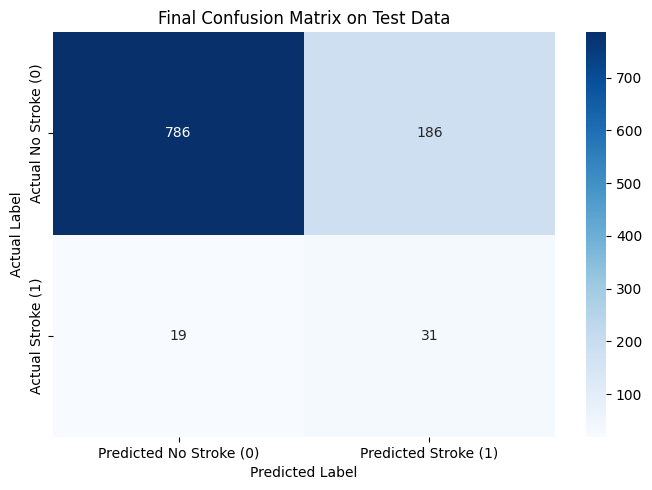

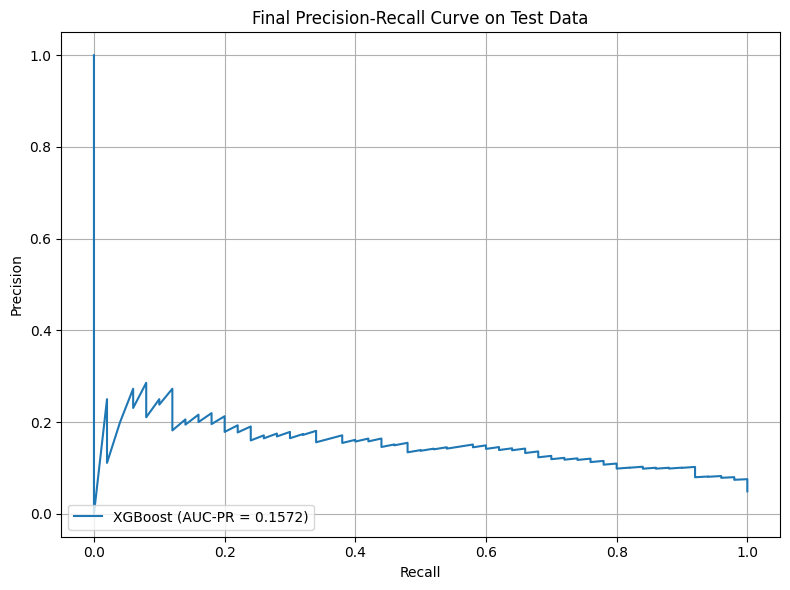

In [16]:
# 1. Get my best model
best_model = grid_search_v3.best_estimator_

# 2. Load the test data
df_test = pd.read_csv("stroke_testing_dataset.csv")

# 3. Prepare the test data and apply the same feature engineering as I did to the training data for my best model
bins = [0, 18.5, 24.9, 29.9, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df_test['bmi_category'] = pd.cut(df_test['bmi'], bins=bins, labels=labels, right=False)

X_test = df_test.drop(columns=['stroke'])
y_test = df_test['stroke']

# 4. Make Predictions
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 5. Generate evaluation metrics and plots
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Stroke (0)', 'Predicted Stroke (1)'],
            yticklabels=['Actual No Stroke (0)', 'Actual Stroke (1)'])
plt.title('Final Confusion Matrix on Test Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
final_auc_pr = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AUC-PR = {final_auc_pr:.4f})')
plt.title('Final Precision-Recall Curve on Test Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
print(f"\nFinal Test Set AUC-PR Score: {final_auc_pr:.4f}")

### Final evaluation

So the final test set AUC-PR score was 0.1572. The fact that this is significantly lower than the AUC-PR scores found during training shows that the model has been overfit to the training data. It still performs well on unseen data - this score is over 3 times better than random guessing. Hence the model built has predictive power but perhaps less than hoped for.

## Bibliography

* [1] https://xgboosting.com/xgboost-for-imbalanced-classification/ 
* [2] https://xgboosting.com/how-to-use-xgboost-xgbclassifier/
* [3] https://xgboosting.com/xgboost-evaluate-model-using-stratified-k-fold-cross-validation/
* [4] https://www.datacamp.com/tutorial/k-fold-cross-validation
* [5] L. Gorgo (2025) Understanding ROC-AUC and PR-AUC. https://medium.com 
* [6] N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer (2002) SMOTE: Synthetic Minority Oversampling Technique. Journal of Artificial Intelligence Research, vol 16, pg. 321-357.
* [7] R. Ravinhara (2023) SMOTE and Other Options: A Comprehensive Guide to Handling Imbalanced Data. https://towardsdatascience.com
* [8] S. Seitz (2022) Why SMOTE is not necessarily the answer to your imbalanced dataset. https://towardsdatascience.com
* [9] https://www.nhs.uk/conditions/obesity/
* [10] https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/ 
* [11] https://xgboosting.com/configure-xgboost-eval_metric-parameter/ 
* [12] https://xgboosting.com/tune-xgboost-max_delta_step-parameter/ 
